### **DCGAN with MNIST Dataset**

**Importing Libraries**

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torchvision import transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display

In [ ]:
criterion=nn.BCEWithLogitsLoss()
epochs=50
z_dim=64
batch_size=128
lr=0.0002
betas=(0.5, 0.999)
device="cuda"
display_step=500

In [ ]:
class Generator(nn.Module):

  def __init__(self, z_dim=10, im_channels=1, hidden_dim=64):
    super().__init__()

    self.generator = nn.Sequential(
        self.generator_block(z_dim, hidden_dim*4),
        self.generator_block(hidden_dim*4, hidden_dim*2, kernel_size=4, stride=1),
        self.generator_block(hidden_dim*2, hidden_dim),
        self.generator_block(hidden_dim, im_channels, kernel_size=4, final_layer=True)
    )

  def generator_block(self, input_chanels, output_chanels, kernel_size=3, stride=2, final_layer=False):
    if not final_layer:
      return nn.Sequential(
          nn.ConvTranspose2d(input_chanels, output_chanels, kernel_size, stride),
          nn.BatchNorm2d(output_chanels),
          nn.ReLU()
      )
    else:
      return nn.Sequential(
          nn.ConvTranspose2d(input_chanels, output_chanels, kernel_size, stride),
          nn.Tanh()
      )

  def forward(self, noise):
    return self.generator(noise)

In [ ]:
generator=Generator(z_dim).to(device)

summary(generator, (z_dim, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
class Discriminator(nn.Module):

  def __init__(self, im_channels=1, hidden_dim=16):
    super().__init__()

    self.discriminator = nn.Sequential(
        self.generator_block(im_channels, hidden_dim),
        self.generator_block(hidden_dim, hidden_dim*2),
        self.generator_block(hidden_dim*2, 1, final_layer=True)
    )

  def generator_block(self, input_chanels, output_chanels, kernel_size=4, stride=2, final_layer=False):
    if not final_layer:
      return nn.Sequential(
          nn.Conv2d(input_chanels, output_chanels, kernel_size, stride),
          nn.BatchNorm2d(output_chanels),
          nn.LeakyReLU(0.2)
      )
    else:
      return nn.Sequential(
          nn.Conv2d(input_chanels, output_chanels, kernel_size, stride)
      )

  def forward(self, noise):
    return self.discriminator(noise)

In [ ]:
discriminator=Discriminator().to(device)

summary(discriminator, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             272
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]           8,224
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7              [-1, 1, 1, 1]             513
Total params: 9,105
Trainable params: 9,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.03
Estimated Total Size (MB): 0.12
----------------------------------------------------------------


In [ ]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

train_dataset=DataLoader(
    MNIST(".", transform=transform, download=True),
    batch_size=batch_size,
    shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 261426558.12it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 28382308.77it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 77486374.65it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13284887.56it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
for im_examples, lb_examples in train_dataset:
  break

im_examples.shape, lb_examples.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [ ]:
im_examples.min(), im_examples.max()

(tensor(-1.), tensor(1.))

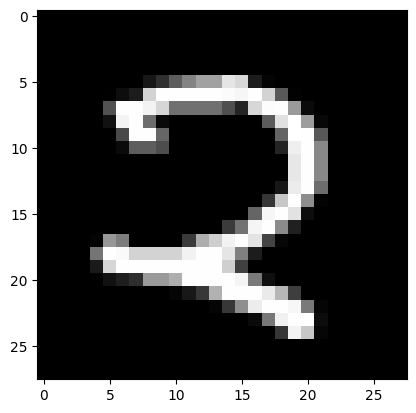

In [ ]:
plt.imshow(im_examples[0].permute(1, 2, 0), cmap="gray");

In [ ]:
gen_optimizer=torch.optim.Adam(generator.parameters(), lr=lr, betas=betas)
disc_optimizer=torch.optim.Adam(discriminator.parameters(), lr=lr, betas=betas)

In [ ]:
def weights_init(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
  if isinstance(m, nn.BatchNorm2d):
     torch.nn.init.normal_(m.weight, 0.0, 0.02)
     torch.nn.init.constant_(m.bias, 0)

generator=generator.apply(weights_init)
discriminator=discriminator.apply(weights_init)

In [ ]:
def show_images(real_images, fake_images, num_images=25, nrow=5, cmap="gray"):

  real_images=real_images.cpu()
  fake_images=fake_images.cpu()

  # Denormalization
  real_images=(real_images+1)/2 #[0., 1.]
  fake_images=(fake_images+1)/2 #[0., 1.]

  real_images=make_grid(real_images[:num_images], nrow=nrow).permute(1, 2, 0)
  fake_images=make_grid(fake_images[:num_images], nrow=nrow).permute(1, 2, 0)

  fig, ax = plt.subplots(1, 2, figsize=(nrow*2, nrow*2))
  ax[0].imshow(fake_images, cmap=cmap)
  ax[0].axis("off")
  ax[0].set_title("Generated Images")

  ax[1].imshow(real_images, cmap=cmap)
  ax[1].axis("off")
  ax[1].set_title("Real Images")

  plt.show()

In [ ]:
def train_gan(epochs=50, display_wait=False):
  step=1
  mean_generator_loss=0
  mean_discriminator_loss=0

  for epoch in range(epochs):
    with tqdm(train_dataset) as pbar:
      pbar.set_description(f"[Epoch: {epoch+1}]")
      for real_images, _ in pbar:
        cur_batch_size=len(real_images)
        real_images=real_images.to(device)

        # Update discriminator
        disc_optimizer.zero_grad()
        noise=torch.randn(cur_batch_size, z_dim, 1, 1, device=device)
        fake_images=generator(noise).detach()
        fake_out=discriminator(fake_images)
        fake_loss=criterion(fake_out, torch.zeros_like(fake_out))

        real_out=discriminator(real_images)
        real_loss=criterion(real_out, torch.ones_like(real_out))

        disc_loss=(fake_loss+real_loss)/2
        disc_loss.backward(retain_graph=True)
        disc_optimizer.step()

        mean_discriminator_loss+=disc_loss.item()/display_step

        # Update Generator
        gen_optimizer.zero_grad()
        noise=torch.randn(cur_batch_size, z_dim, 1, 1, device=device)
        fake_images=generator(noise)
        fake_out=discriminator(fake_images)
        gen_loss=criterion(fake_out, torch.ones_like(fake_out))

        gen_loss.backward(retain_graph=True)
        gen_optimizer.step()

        mean_generator_loss+=gen_loss.item()/display_step

        #Visualization
        pbar.set_postfix({"Step": step, "gen_loss": gen_loss.item(), "disc_loss": disc_loss.item()})

        if step%display_step==0:
          display.clear_output(wait=display_wait)
          print(f"Epoch {epoch+1}, Step {step}: MeanGeneratorLoss: {mean_generator_loss}, MeanDiscriminatorLoss: {mean_discriminator_loss}")
          noise=torch.randn(cur_batch_size, z_dim, 1, 1, device=device)
          fake_images=generator(noise).detach()

          show_images(real_images, fake_images)

          mean_generator_loss=0
          mean_discriminator_loss=0

        step+=1

Epoch 50, Step 23000: MeanGeneratorLoss: 0.7036839723587037, MeanDiscriminatorLoss: 0.6952423801422116


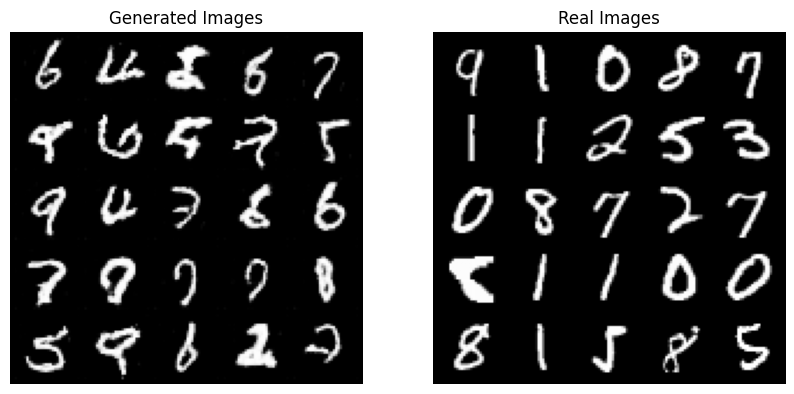

[Epoch: 50]: 100%|██████████| 469/469 [00:24<00:00, 18.95it/s, Step=23450, gen_loss=0.698, disc_loss=0.698]


In [ ]:
train_gan(epochs=epochs)

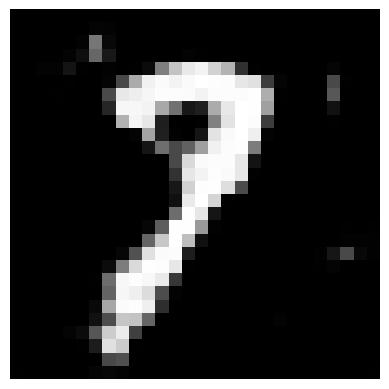

In [ ]:
example=torch.randn(1, z_dim, 1, 1, device=device)
generated_example=generator(example).detach().cpu().squeeze().numpy()
plt.imshow(generated_example, cmap="gray")
plt.axis("off");